# Bayesian amplitude regression

In the lectures you should've now covered, or at least discussed Bayesian networks.  Here we'll show you how to build these networks and use them in practice.

We will start by constructing a Bayesian layer in pytorch, and then building the Bayesian loss function.  We will then construct a Bayesian network from these layers, and use it to perform the same amplitude regression from the previous tutorial.  We will discuss how to analyse the outputs of the Bayesian network, and how this gives us the ability to estimate the error on our analysis.  This last step is crucial to the application of any numerical technique in physics.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
 - Visualising the data
     - visualise some of the kinematics of the process (transverse momentum of photons/gluons, MET)
     - histogram the amplitudes
 - Preprocessing the data
     - neural networks like $\mathcal{O}(1)$ numbers
     - how should we preprocess the data?
 - Datasets and dataloaders
     - details are in the pytorch docs
 - Building a Bayesian layer
 - Constructing the Bayesian loss function
 - Building the Bayesian neural network
 - Optimising the neural network
 - Plot the train and validation losses as a function of the epochs
 - Study the results

     
Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Loading the data

In [3]:
trn_dat = np.load( "tutorial-2-data/trn_dat.npy" )
trn_amp = np.load( "tutorial-2-data/trn_amp.npy" )

val_dat = np.load( "tutorial-2-data/val_dat.npy" )
val_amp = np.load( "tutorial-2-data/val_amp.npy" )

tst_dat = np.load( "tutorial-2-data/tst_dat.npy" )
tst_amp = np.load( "tutorial-2-data/tst_amp.npy" )

In [4]:
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )
print( f"test  data shape: {tst_dat.shape}" )
print( f"test  amp  shape: {tst_amp.shape}" )
print( f"val   data shape: {val_dat.shape}" )
print( f"val   amp  shape: {val_amp.shape}" )

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


We will not repeat the visualisation of the data, see the previous tutorial for this.

## Preprocessing the data

In [5]:
def get_pt( fv ):
    ptsq = np.round( fv[1]**2 + fv[2]**2 , 5 )
    if ptsq>0:
        return np.sqrt( ptsq )
    elif ptsq<0:
        raise Exception( "$p_T$ squared is less than zero" ) 
    else:
        return 0

In [6]:
trn_dat_gluon_pt = []
for ev in trn_dat:
    trn_dat_gluon_pt.append( get_pt( ev[2] ) )

In [7]:
nev = trn_dat.shape[0]
trn_datf = np.reshape( trn_dat, (nev,-1) )
val_datf = np.reshape( val_dat, (nev,-1) )
tst_datf = np.reshape( tst_dat, (nev,-1) )

In [8]:
trn_datf.shape

(30000, 20)

In [9]:
gpt = np.mean( trn_dat_gluon_pt )
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

In [10]:
trn_datfp = torch.Tensor( trn_datf )
val_datfp = torch.Tensor( val_datf )
tst_datfp = torch.Tensor( tst_datf )

In [11]:
trn_ampl = np.log( trn_amp )
val_ampl = np.log( val_amp )
tst_ampl = np.log( tst_amp )

In [12]:
trn_amplp = torch.Tensor( trn_ampl )
val_amplp = torch.Tensor( val_ampl )
tst_amplp = torch.Tensor( tst_ampl )

## Datasets and dataloaders

In [13]:
class amp_dataset( Dataset ):
    
    def __init__( self, data, amp ):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [14]:
trn_dataset = amp_dataset( trn_datfp, trn_amplp.unsqueeze(-1) )
val_dataset = amp_dataset( val_datfp, val_amplp.unsqueeze(-1) )
tst_dataset = amp_dataset( tst_datfp, tst_amplp.unsqueeze(-1) )

In [15]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

In [16]:
next( iter( trn_dataloader ) )[0].shape

torch.Size([64, 20])

In [17]:
next( iter( trn_dataloader ) )[1].shape

torch.Size([64, 1])

## Building a Bayesian layer

First let's look at the source code for a **basic linear layer** in pytorch:

(https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

In [18]:
class Linear(Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

Objects of this class apply a linear transformation to the incoming data: $y = xA^T + b$.

The input arguments are required to initialise the layer, so, in the \_\_init()\_\_ function.  We have:
- in_features: size of each input sample
- out_features: size of each output sample
- bias: If set to ``False``, the layer will not learn an additive bias.  Default: ``True``

The shapes are:
- Input: $(*, H_{in})$ where $*$ means any number of dimensions including none and $H_{in} = \text{in_features}$.
- Output: $(*, H_{out})$ where all but the last dimension are the same shape as the input and $H_{out} = \text{out_features}$.

The layer has attributes:
- weight: the learnable weights of the module of shape $(\text{out_features}, \text{in_features})$. The values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in_features}}$
- bias:   the learnable bias of the module of shape $(\text{out_features})$.  If `bias` is ``True``, the values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where $k = \frac{1}{\text{in_features}}$.

Examples::

    >>> m = nn.Linear(20, 30)
    
    >>> input = torch.randn(128, 20)
    
    >>> output = m(input)
    
    >>> print(output.size())
    
    torch.Size([128, 30])

From the lecture, we know that in a Bayesian network the weights are replaced by Gaussian distributions, and on a forward pass we get the output by sampling from that distribution.

So the biases are the same as in the linear layer.  But not each weight is a Gaussian distibution and so needs a mean and a variance.  The bias and the mean and variance of the weight distribution will be learnable.  In practice it's easier to work with the log of the variance as it is more stable when optimising the network.

We need to be able to sample from the Gaussian weight distributions, and compute derivatives of the output in order to update the network parameters.  To do this we use something called the 're-parameterisation trick'.  It involves sampling random noise from a unit normal distribution, and then transforming that number using the mean and variance of the weight distribution in this way:
\begin{equation}
w = \mu + \sigma\times r
\end{equation}
where $r$ is a random number sampled from a unit normal distribution (Gaussian with mean and variance equal to one), $\mu$ is the mean of the weight distribution, and $\sigma$ is the standard deviation.  In this way we separate the stochastic part of the function from the parameters defining the distribution.  And so if we take any differentiable function of $x$ (e.g. an activation function), we can compute derivatives of that function with respect to the mean and variance of the weight distribution.

In the `forward` method we then need to implement this reparameterisation trick for the weights, and then apply the same linear transformation as in the standard linear layer.

On each forward pass we need to generate a set of random numbers with the same shape as our means and variances.  Choosing a set of random numbers for the sampling is equivalent to 'sampling' a new neural network from the Bayesian neural network.  And sometimes at the end of the analysis, we will want to keep the same network for testing.  So we don't always want to re-sample the random numbers on each forward pass.  To control this we define a flag called `self.resample`, with default set to ``True``.

We also need a `reset_parameters` function to reset the parameters in the network.  This is standard for layers in pytorch.  We use a slightly different function to do this than is used in the pytorch linear layer, as can be seen below.

From the lecture, you know that the weight distributions require a prior.  The simplest choice for this prior is just a Gaussian distribution with a mean and variance of one.  Results are typically not too sensitive to this prior, as long as the values are within reasonable limits.  For example, $\mathcal{O}(1)$ means and standard deviations.  Going beyond $\mathcal{O}(1)$ numbers just leads to numerical instabilities in the training.  The Bayesian loss function contains a term coming from the KL divergence between the weight distributions in the network and their priors.  So the layers should have some funcitonality to return these values.  The KL divergence for the layer is:
\begin{equation}
\text{KL} = \sum_{\text{weights}} 0.5 \times (  \mu^2 + \sigma^2 - \log\sigma^2 - 1 )
\end{equation}

So let's build the **simplest Bayesian layer** we can.

In [19]:
class VBLinear( Module ):
    # VB -> Variational Bayes
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    
    def __init__( self, in_features, out_features ):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = Parameter( Tensor( out_features ) )
        self.mu_w = Parameter( Tensor( out_features, in_features ) )
        self.logsig2_w = Parameter( Tensor( out_features, in_features ) )
        self.random = torch.randn_like( self.logsig2_w )
        self.reset_parameters()
        
    def forward( self, input ):
        if self.resample:
            self.random = torch.randn_like( self.logsig2_w )
        s2_w = self.logsig2_w.exp()
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear( input, weight, self.bias ) #+ 1e-8
    
    def reset_parameters( self ):
        stdv = 1. / np.sqrt( self.mu_w.size(1) )
        self.mu_w.data.normal_( 0, stdv )
        self.logsig2_w.data.zero_().normal_( -9, 0.001 )
        self.bias.data.zero_()
        
    def KL( self, loguniform=False ):
        kl = 0.5 * ( self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1 ).sum()
        return kl

Let's test the layers, define:

In [20]:
tlr0 = VBLinear( 10, 5 )
tlr1 = VBLinear( 5, 2 )

Now some test data, a batch of 20 vectors with 10 elements each:

In [21]:
x = torch.rand( 20, 10 )

Now pass the data first through layer0 then through layer1:

In [23]:
tlr1( tlr0( x ) )

tensor([[ 0.1523,  0.1869],
        [ 0.1706,  0.3295],
        [ 0.0875,  0.3682],
        [-0.1234,  0.3718],
        [ 0.6967,  0.7880],
        [ 0.1683,  0.2134],
        [ 0.0435,  0.5645],
        [ 0.0617,  0.4357],
        [ 0.1835,  0.8228],
        [-0.0303,  0.1618],
        [ 0.5201,  0.7970],
        [ 0.1258,  0.4622],
        [ 0.2583,  0.5258],
        [ 0.1353,  0.4262],
        [ 0.3772,  0.2814],
        [ 0.0777,  0.5676],
        [ 0.3921,  0.4807],
        [-0.1868, -0.1350],
        [-0.0236,  0.0432],
        [ 0.3496,  0.1937]], grad_fn=<AddmmBackward0>)

Note this has the correct shape:

In [24]:
tlr1( tlr0( x ) ).shape

torch.Size([20, 2])

Also try running the same data through the layer multiple times, you get different results.  This is because of the sampling in the Bayesian layer.

In [25]:
for i in range(5):
    print(tlr0(x)[0][0])

tensor(0.5897, grad_fn=<SelectBackward0>)
tensor(0.5777, grad_fn=<SelectBackward0>)
tensor(0.5939, grad_fn=<SelectBackward0>)
tensor(0.5936, grad_fn=<SelectBackward0>)
tensor(0.6032, grad_fn=<SelectBackward0>)


## The Bayesian loss function

From the lectures we know that there are two parts to the Bayesian loss function:
- The negative log Gaussian
- the KL from the network weights

The second comes from the layers, and the first is defined below.  This negative log Gaussian term acts on the two outputs from the Bayesian neural network:
- the mean
- the variance (which we parameterise as the log variance)

In [26]:
def neg_log_gauss( outputs, targets ):

    mu = outputs[:, 0]
    logsigma2 = outputs[:, 1]
    out = torch.pow( mu - targets, 2 ) / ( 2 * logsigma2.exp() ) + 1./2. * logsigma2
    
    return torch.mean(out)

## Building the Bayesian neural network

We'll build a simple network with one input and one output layer, and two hidden layers.  We define the dimensions of these layers below.

In [27]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 50

Now we build a very simple class for our neural network, which we call amp_net.

In [28]:
class bayes_amp_net( Module ):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__( self, training_size, hdn_dim=50 ):
        
        super( bayes_amp_net, self ).__init__()
        
        # the loss function depends on the amount of training data we have, so we need to store this
        self.training_size = training_size
        
        # the activation layers of the network are not bayesian
        # and we need to be able to access the bayesian layers separately
        
        self.vb_layers = []
        self.all_layers = []
        
        # define the input layer
        vb_layer = VBLinear( ipt_dim, hdn_dim )
        self.vb_layers.append( vb_layer )
        self.all_layers.append( vb_layer )
        self.all_layers.append( nn.ReLU() )
        
        # loop over hidden layers
        for i in range(2):
            vb_layer = VBLinear( hdn_dim, hdn_dim )
            self.vb_layers.append( vb_layer )
            self.all_layers.append( vb_layer )
            self.all_layers.append( nn.ReLU() )
        
        # define the output layer
        vb_layer = VBLinear( hdn_dim, 2 )
        self.vb_layers.append( vb_layer )
        self.all_layers.append( vb_layer )
        
        # define the model as a Sequential net over all layers
        self.model = nn.Sequential(*self.all_layers)

    # and of course the forward function
    def forward( self, x ):
        out = self.model( x )
        return out
    
    # we need the KL from the bayesian layers to compute the loss function
    def KL( self ):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size
    
    # let's put the neg_log_gauss in the network class aswell since it is key to bayesian networks
    def neg_log_gauss( self, outputs, targets ):
        mu = outputs[:, 0]
        logsigma2 = outputs[:, 1]
        out = torch.pow( mu - targets, 2 ) / ( 2 * logsigma2.exp() ) + 1./2. * logsigma2
        return torch.mean(out)

Check if we have a GPU.

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Initialise the neural network and send to the GPU if we have one.  We can also print the model to see what layers it has.

In [30]:
trn_len = trn_amplp.shape[0]
hdn_dim = 50
model = bayes_amp_net( trn_len, hdn_dim=hdn_dim ).to(device)
print(model)

bayes_amp_net(
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)


Now we can test it briefly by throwing some random numbers into it.

In [39]:
X = torch.rand(5, 20, device=device)

Passing the numbers through the Bayesian network gives us different outputs each time we run it:

In [40]:
model( X )

tensor([[-0.0588,  0.0313],
        [-0.3057,  0.0786],
        [-0.2172, -0.0391],
        [-0.3509,  0.1364],
        [-0.1802, -0.0766]], grad_fn=<AddmmBackward0>)

Note again that the output has the correct shape:

In [41]:
model( X ).shape

torch.Size([5, 2])

The predicitons of the full Bayesian network should vary with each forward pass because of the weight sampling

In [42]:
# print predictions for the same input data
for i in range(5):
    print(model( X )[0])

tensor([-0.1066,  0.0385], grad_fn=<SelectBackward0>)
tensor([-0.0911,  0.0146], grad_fn=<SelectBackward0>)
tensor([-0.0795, -0.0063], grad_fn=<SelectBackward0>)
tensor([-0.0723, -0.0150], grad_fn=<SelectBackward0>)
tensor([-0.0640,  0.0576], grad_fn=<SelectBackward0>)


## Optimising (training) the neural network

The Bayesian loss function has two terms which we have already definedl; the negative los Gaussian, and the KL divergence between the network and the network prior.  The latter comes from the KL divergence over the weights in the network.

Now we can write a training loop for a single epoch.

In [43]:
def train_epoch( dataloader, model, optimizer ):

    size = len( dataloader.dataset )
    model.train()
    loss_tot, kl_tot, neg_log_tot = 0.0, 0.0, 0.0
    
    for batch, (X, y) in enumerate( dataloader ):
        
        # pass data through network
        pred = model(X)
        
        # compute loss
        nl = model.neg_log_gauss( pred, y.reshape(-1) )
        kl = model.KL()
        loss = nl + kl
        
        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            current = batch * len( X )
            print(f"current batch loss: {loss:>8f} KL: {kl:>8f} Neg-log {nl:>8f}  [{current:>5d}/{size:>5d}]")

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [44]:
def val_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    nls = 0.0
    kls = 0.0
    vls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            nl = model.neg_log_gauss( pred, y.reshape(-1) )
            kl = model.KL()
            vl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            vls += vl

    nls /= num_batches
    kls /= num_batches
    vls /= num_batches
    mse /= num_batches
    print( f"avg val loss per batch: {vls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )
    
    return nls, kls, vls, mse

def trn_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    nls = 0.0
    kls = 0.0
    tls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            nl = model.neg_log_gauss( pred, y.reshape(-1) )
            kl = model.KL()
            tl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            tls += tl

    nls /= num_batches
    kls /= num_batches
    tls /= num_batches
    mse /= num_batches
    print( f"avg trn loss per batch: {tls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )
    
    return nls, kls, tls, mse

Now we can train the model!

In [46]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# reset some parameters
batch_size = 128
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )
epochs = 500

# re-initialise the model and the optimizer
hdn_dim = 50
trn_len = trn_amplp.shape[0]
print(f"Training dataset length: {trn_len}")
model = bayes_amp_net( trn_len, hdn_dim=hdn_dim ).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
seperator()
print( "model architecture ")
seperator()
print( model )

# track train and val losses
trn_nl_losses = []
trn_kl_losses = []
trn_losses = []
trn_mse_losses = []
val_nl_losses = []
val_kl_losses = []
val_losses = []
val_mse_losses = []

for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model, optimizer )
    seperator()
    trn_nl_loss, trn_kl_loss, trn_loss, trn_mse_loss = trn_pass( trn_dataloader, model )
    trn_nl_losses.append( trn_nl_loss )
    trn_kl_losses.append( trn_kl_loss )
    trn_losses.append( trn_loss )
    trn_mse_losses.append(trn_mse_loss)
    seperator()
    val_nl_loss, val_kl_loss, val_loss, val_mse_loss = val_pass( val_dataloader, model )
    val_nl_losses.append( val_nl_loss )
    val_kl_losses.append( val_kl_loss )
    val_losses.append( val_loss )
    val_mse_losses.append( val_mse_loss )
    seperator()
    print( "|" )
    
print("Done!")

Training dataset length: 30000
-----------------------------------------------
model architecture 
-----------------------------------------------
bayes_amp_net(
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 166.389908 KL: 0.815809 Neg-log 165.574097  [    0/30000]
current batch loss: 6.421925 KL: 0.813876 Neg-log 5.608048  [12800/30000]
current batch loss: 4.599923 KL: 0.812010 Neg-log 3.787913  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 4.630536 KL: 0.811385 Neg-log 3.819155 MSE 145.4280548095703
-----------------------------------------------
avg val loss per batch: 4.629337 KL: 0.811385 Neg-log 3.817955 MSE 145.0192108154297
-----------------------------------------------
|
-----------------------------------

current batch loss: 0.781292 KL: 0.773356 Neg-log 0.007936  [12800/30000]
current batch loss: 1.124421 KL: 0.772077 Neg-log 0.352344  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.910159 KL: 0.771632 Neg-log 0.138529 MSE 0.8536414504051208
-----------------------------------------------
avg val loss per batch: 0.932575 KL: 0.771632 Neg-log 0.160944 MSE 0.93007892370224
-----------------------------------------------
|
-----------------------------------------------
Epoch 14
-----------------------------------------------
current batch loss: 0.767457 KL: 0.771630 Neg-log -0.004173  [    0/30000]
current batch loss: 0.746486 KL: 0.770360 Neg-log -0.023873  [12800/30000]
current batch loss: 0.901205 KL: 0.769096 Neg-log 0.132108  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.852264 KL: 0.768647 Neg-log 0.083616 MSE 0.7513139843940735
-----------------------------------------------
avg val loss per batch: 0

current batch loss: 0.251690 KL: 0.735757 Neg-log -0.484068  [12800/30000]
current batch loss: 0.560733 KL: 0.734662 Neg-log -0.173929  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 1.047139 KL: 0.734274 Neg-log 0.312863 MSE 0.7343472242355347
-----------------------------------------------
avg val loss per batch: 1.053655 KL: 0.734274 Neg-log 0.319379 MSE 0.7715469002723694
-----------------------------------------------
|
-----------------------------------------------
Epoch 27
-----------------------------------------------
current batch loss: 2.059685 KL: 0.734275 Neg-log 1.325410  [    0/30000]
current batch loss: 0.939454 KL: 0.733174 Neg-log 0.206280  [12800/30000]
current batch loss: 0.984314 KL: 0.732076 Neg-log 0.252238  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.582473 KL: 0.731685 Neg-log -0.149212 MSE 0.3732471466064453
-----------------------------------------------
avg val loss per batch

current batch loss: 0.265572 KL: 0.704050 Neg-log -0.438479  [12800/30000]
current batch loss: 0.185980 KL: 0.703102 Neg-log -0.517122  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.780762 KL: 0.702769 Neg-log 0.077993 MSE 0.5381796956062317
-----------------------------------------------
avg val loss per batch: 0.875189 KL: 0.702769 Neg-log 0.172420 MSE 0.5998108983039856
-----------------------------------------------
|
-----------------------------------------------
Epoch 40
-----------------------------------------------
current batch loss: 1.133373 KL: 0.702769 Neg-log 0.430605  [    0/30000]
current batch loss: 0.403564 KL: 0.701810 Neg-log -0.298246  [12800/30000]
current batch loss: 0.238435 KL: 0.700819 Neg-log -0.462385  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.335500 KL: 0.700479 Neg-log -0.364979 MSE 0.2798926532268524
-----------------------------------------------
avg val loss per bat

current batch loss: 0.076022 KL: 0.674734 Neg-log -0.598712  [12800/30000]
current batch loss: 0.203019 KL: 0.673826 Neg-log -0.470807  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.139043 KL: 0.673508 Neg-log -0.534464 MSE 0.19339749217033386
-----------------------------------------------
avg val loss per batch: 0.155752 KL: 0.673508 Neg-log -0.517755 MSE 0.19455569982528687
-----------------------------------------------
|
-----------------------------------------------
Epoch 53
-----------------------------------------------
current batch loss: 0.046482 KL: 0.673507 Neg-log -0.627025  [    0/30000]
current batch loss: 0.820847 KL: 0.672617 Neg-log 0.148230  [12800/30000]
current batch loss: -0.024227 KL: 0.671716 Neg-log -0.695943  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.189099 KL: 0.671412 Neg-log -0.482313 MSE 0.20372642576694489
-----------------------------------------------
avg val loss p

current batch loss: 0.710941 KL: 0.648446 Neg-log 0.062496  [12800/30000]
current batch loss: -0.097433 KL: 0.647644 Neg-log -0.745077  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.041178 KL: 0.647374 Neg-log -0.606196 MSE 0.15268108248710632
-----------------------------------------------
avg val loss per batch: 0.026863 KL: 0.647374 Neg-log -0.620511 MSE 0.14528286457061768
-----------------------------------------------
|
-----------------------------------------------
Epoch 66
-----------------------------------------------
current batch loss: 0.097052 KL: 0.647374 Neg-log -0.550322  [    0/30000]
current batch loss: -0.099691 KL: 0.646583 Neg-log -0.746275  [12800/30000]
current batch loss: -0.176513 KL: 0.645794 Neg-log -0.822307  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.141098 KL: 0.645524 Neg-log -0.504427 MSE 0.20757700502872467
-----------------------------------------------
avg val loss

current batch loss: 0.169085 KL: 0.626964 Neg-log -0.457879  [12800/30000]
current batch loss: -0.247504 KL: 0.626356 Neg-log -0.873860  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.045749 KL: 0.626146 Neg-log -0.671896 MSE 0.14252755045890808
-----------------------------------------------
avg val loss per batch: -0.061862 KL: 0.626146 Neg-log -0.688010 MSE 0.1390758603811264
-----------------------------------------------
|
-----------------------------------------------
Epoch 79
-----------------------------------------------
current batch loss: -0.184863 KL: 0.626147 Neg-log -0.811010  [    0/30000]
current batch loss: -0.124812 KL: 0.625565 Neg-log -0.750378  [12800/30000]
current batch loss: -0.222846 KL: 0.624971 Neg-log -0.847817  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.092414 KL: 0.624762 Neg-log -0.717177 MSE 0.1284596472978592
-----------------------------------------------
avg val l

avg val loss per batch: -0.137102 KL: 0.611136 Neg-log -0.748238 MSE 0.10665684938430786
-----------------------------------------------
|
-----------------------------------------------
Epoch 91
-----------------------------------------------
current batch loss: 0.275370 KL: 0.611136 Neg-log -0.335766  [    0/30000]
current batch loss: -0.304921 KL: 0.610637 Neg-log -0.915559  [12800/30000]
current batch loss: 0.969881 KL: 0.610129 Neg-log 0.359752  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.151352 KL: 0.609948 Neg-log -0.761300 MSE 0.13101966679096222
-----------------------------------------------
avg val loss per batch: -0.140905 KL: 0.609948 Neg-log -0.750853 MSE 0.1360824555158615
-----------------------------------------------
|
-----------------------------------------------
Epoch 92
-----------------------------------------------
current batch loss: -0.023175 KL: 0.609948 Neg-log -0.633123  [    0/30000]
current batch loss: -0.2878

current batch loss: -0.167525 KL: 0.599571 Neg-log -0.767096  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.295774 KL: 0.599472 Neg-log -0.895247 MSE 0.09382954239845276
-----------------------------------------------
avg val loss per batch: -0.304690 KL: 0.599472 Neg-log -0.904163 MSE 0.09316863119602203
-----------------------------------------------
|
-----------------------------------------------
Epoch 104
-----------------------------------------------
current batch loss: -0.327907 KL: 0.599473 Neg-log -0.927380  [    0/30000]
current batch loss: -0.389447 KL: 0.599193 Neg-log -0.988640  [12800/30000]
current batch loss: -0.354919 KL: 0.598923 Neg-log -0.953843  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.351561 KL: 0.598825 Neg-log -0.950387 MSE 0.08391109853982925
-----------------------------------------------
avg val loss per batch: -0.315897 KL: 0.598825 Neg-log -0.914722 MSE 0.0920531675

current batch loss: 0.403128 KL: 0.592239 Neg-log -0.189111  [12800/30000]
current batch loss: -0.502284 KL: 0.592003 Neg-log -1.094287  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.191485 KL: 0.591913 Neg-log -0.783399 MSE 0.10734901577234268
-----------------------------------------------
avg val loss per batch: -0.278742 KL: 0.591913 Neg-log -0.870656 MSE 0.09175027161836624
-----------------------------------------------
|
-----------------------------------------------
Epoch 117
-----------------------------------------------
current batch loss: -0.625952 KL: 0.591914 Neg-log -1.217866  [    0/30000]
current batch loss: -0.469277 KL: 0.591692 Neg-log -1.060969  [12800/30000]
current batch loss: -0.224245 KL: 0.591445 Neg-log -0.815690  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.297141 KL: 0.591368 Neg-log -0.888508 MSE 0.08756408095359802
-----------------------------------------------
avg va

avg val loss per batch: -0.313408 KL: 0.585341 Neg-log -0.898747 MSE 0.081090047955513
-----------------------------------------------
|
-----------------------------------------------
Epoch 129
-----------------------------------------------
current batch loss: -0.604582 KL: 0.585340 Neg-log -1.189922  [    0/30000]
current batch loss: -0.181807 KL: 0.585115 Neg-log -0.766923  [12800/30000]
current batch loss: -0.046402 KL: 0.584877 Neg-log -0.631279  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.457179 KL: 0.584793 Neg-log -1.041972 MSE 0.06575176864862442
-----------------------------------------------
avg val loss per batch: -0.408460 KL: 0.584793 Neg-log -0.993253 MSE 0.07334408909082413
-----------------------------------------------
|
-----------------------------------------------
Epoch 130
-----------------------------------------------
current batch loss: -0.616121 KL: 0.584793 Neg-log -1.200914  [    0/30000]
current batch loss: -0.

current batch loss: -0.698338 KL: 0.578681 Neg-log -1.277019  [12800/30000]
current batch loss: -0.575861 KL: 0.578453 Neg-log -1.154314  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.456821 KL: 0.578379 Neg-log -1.035201 MSE 0.06400676816701889
-----------------------------------------------
avg val loss per batch: -0.421882 KL: 0.578379 Neg-log -1.000262 MSE 0.06660477817058563
-----------------------------------------------
|
-----------------------------------------------
Epoch 142
-----------------------------------------------
current batch loss: -0.436729 KL: 0.578380 Neg-log -1.015109  [    0/30000]
current batch loss: -0.516815 KL: 0.578146 Neg-log -1.094961  [12800/30000]
current batch loss: -0.530620 KL: 0.577894 Neg-log -1.108514  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.510108 KL: 0.577805 Neg-log -1.087913 MSE 0.05772379785776138
-----------------------------------------------
avg v

avg val loss per batch: -0.279788 KL: 0.572144 Neg-log -0.851932 MSE 0.07564432919025421
-----------------------------------------------
|
-----------------------------------------------
Epoch 154
-----------------------------------------------
current batch loss: 0.025764 KL: 0.572144 Neg-log -0.546380  [    0/30000]
current batch loss: -0.733255 KL: 0.571900 Neg-log -1.305155  [12800/30000]
current batch loss: -0.081127 KL: 0.571668 Neg-log -0.652795  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.582139 KL: 0.571586 Neg-log -1.153724 MSE 0.052275143563747406
-----------------------------------------------
avg val loss per batch: -0.501373 KL: 0.571586 Neg-log -1.072957 MSE 0.06086325645446777
-----------------------------------------------
|
-----------------------------------------------
Epoch 155
-----------------------------------------------
current batch loss: -0.589299 KL: 0.571585 Neg-log -1.160884  [    0/30000]
current batch loss: -

current batch loss: -0.524571 KL: 0.565666 Neg-log -1.090237  [12800/30000]
current batch loss: -0.643184 KL: 0.565442 Neg-log -1.208627  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.619869 KL: 0.565369 Neg-log -1.185237 MSE 0.053565822541713715
-----------------------------------------------
avg val loss per batch: -0.629112 KL: 0.565369 Neg-log -1.194481 MSE 0.052445027977228165
-----------------------------------------------
|
-----------------------------------------------
Epoch 167
-----------------------------------------------
current batch loss: -1.014778 KL: 0.565368 Neg-log -1.580146  [    0/30000]
current batch loss: -0.856363 KL: 0.565151 Neg-log -1.421514  [12800/30000]
current batch loss: -0.715484 KL: 0.564957 Neg-log -1.280441  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.640108 KL: 0.564873 Neg-log -1.204981 MSE 0.050747115164995193
-----------------------------------------------
av

avg val loss per batch: -0.626381 KL: 0.559326 Neg-log -1.185707 MSE 0.05517309159040451
-----------------------------------------------
|
-----------------------------------------------
Epoch 179
-----------------------------------------------
current batch loss: -0.703757 KL: 0.559326 Neg-log -1.263083  [    0/30000]
current batch loss: -0.301691 KL: 0.559130 Neg-log -0.860821  [12800/30000]
current batch loss: -0.894426 KL: 0.558913 Neg-log -1.453339  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.720841 KL: 0.558839 Neg-log -1.279681 MSE 0.04311714321374893
-----------------------------------------------
avg val loss per batch: -0.727236 KL: 0.558839 Neg-log -1.286076 MSE 0.041266705840826035
-----------------------------------------------
|
-----------------------------------------------
Epoch 180
-----------------------------------------------
current batch loss: -0.606131 KL: 0.558840 Neg-log -1.164971  [    0/30000]
current batch loss: 

current batch loss: -0.848912 KL: 0.552917 Neg-log -1.401830  [12800/30000]
current batch loss: -0.935997 KL: 0.552704 Neg-log -1.488701  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.779000 KL: 0.552635 Neg-log -1.331635 MSE 0.03969622403383255
-----------------------------------------------
avg val loss per batch: -0.751361 KL: 0.552635 Neg-log -1.303995 MSE 0.040338192135095596
-----------------------------------------------
|
-----------------------------------------------
Epoch 192
-----------------------------------------------
current batch loss: -0.469608 KL: 0.552634 Neg-log -1.022242  [    0/30000]
current batch loss: -0.873560 KL: 0.552430 Neg-log -1.425990  [12800/30000]
current batch loss: -0.767995 KL: 0.552231 Neg-log -1.320226  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.690726 KL: 0.552163 Neg-log -1.242890 MSE 0.041199907660484314
-----------------------------------------------
avg

avg val loss per batch: -0.573546 KL: 0.547014 Neg-log -1.120562 MSE 0.05485197529196739
-----------------------------------------------
|
-----------------------------------------------
Epoch 204
-----------------------------------------------
current batch loss: -0.157390 KL: 0.547016 Neg-log -0.704406  [    0/30000]
current batch loss: -0.891449 KL: 0.546809 Neg-log -1.438257  [12800/30000]
current batch loss: -0.838437 KL: 0.546622 Neg-log -1.385059  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.822608 KL: 0.546555 Neg-log -1.369162 MSE 0.03801640123128891
-----------------------------------------------
avg val loss per batch: -0.786627 KL: 0.546555 Neg-log -1.333182 MSE 0.04207395762205124
-----------------------------------------------
|
-----------------------------------------------
Epoch 205
-----------------------------------------------
current batch loss: -0.812088 KL: 0.546555 Neg-log -1.358643  [    0/30000]
current batch loss: -

current batch loss: -0.973982 KL: 0.541955 Neg-log -1.515937  [12800/30000]
current batch loss: -0.948433 KL: 0.541795 Neg-log -1.490229  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.849643 KL: 0.541749 Neg-log -1.391392 MSE 0.03412996977567673
-----------------------------------------------
avg val loss per batch: -0.801430 KL: 0.541749 Neg-log -1.343180 MSE 0.03694286569952965
-----------------------------------------------
|
-----------------------------------------------
Epoch 217
-----------------------------------------------
current batch loss: -1.066455 KL: 0.541750 Neg-log -1.608204  [    0/30000]
current batch loss: -1.032425 KL: 0.541582 Neg-log -1.574007  [12800/30000]
current batch loss: -0.841316 KL: 0.541441 Neg-log -1.382757  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.859302 KL: 0.541382 Neg-log -1.400685 MSE 0.034155841916799545
-----------------------------------------------
avg 

avg val loss per batch: -0.896963 KL: 0.537187 Neg-log -1.434150 MSE 0.030943728983402252
-----------------------------------------------
|
-----------------------------------------------
Epoch 229
-----------------------------------------------
current batch loss: -0.340561 KL: 0.537188 Neg-log -0.877749  [    0/30000]
current batch loss: -0.631570 KL: 0.537017 Neg-log -1.168586  [12800/30000]
current batch loss: -0.701468 KL: 0.536864 Neg-log -1.238332  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.888582 KL: 0.536811 Neg-log -1.425392 MSE 0.03302214667201042
-----------------------------------------------
avg val loss per batch: -0.853987 KL: 0.536811 Neg-log -1.390797 MSE 0.035906143486499786
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: -1.014513 KL: 0.536810 Neg-log -1.551323  [    0/30000]
current batch loss:

current batch loss: -1.182626 KL: 0.532537 Neg-log -1.715164  [12800/30000]
current batch loss: -0.150493 KL: 0.532387 Neg-log -0.682880  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.920784 KL: 0.532335 Neg-log -1.453121 MSE 0.029092492535710335
-----------------------------------------------
avg val loss per batch: -0.900584 KL: 0.532335 Neg-log -1.432920 MSE 0.031164037063717842
-----------------------------------------------
|
-----------------------------------------------
Epoch 242
-----------------------------------------------
current batch loss: -0.827192 KL: 0.532337 Neg-log -1.359529  [    0/30000]
current batch loss: -1.028061 KL: 0.532176 Neg-log -1.560237  [12800/30000]
current batch loss: -1.033387 KL: 0.532038 Neg-log -1.565425  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.992586 KL: 0.531982 Neg-log -1.524569 MSE 0.02683008834719658
-----------------------------------------------
avg

avg val loss per batch: -0.873172 KL: 0.527939 Neg-log -1.401113 MSE 0.03146633505821228
-----------------------------------------------
|
-----------------------------------------------
Epoch 254
-----------------------------------------------
current batch loss: -0.686828 KL: 0.527941 Neg-log -1.214769  [    0/30000]
current batch loss: -0.007262 KL: 0.527790 Neg-log -0.535052  [12800/30000]
current batch loss: -0.758634 KL: 0.527645 Neg-log -1.286279  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.028463 KL: 0.527603 Neg-log -1.556066 MSE 0.02505706436932087
-----------------------------------------------
avg val loss per batch: -1.020700 KL: 0.527603 Neg-log -1.548304 MSE 0.0251461174339056
-----------------------------------------------
|
-----------------------------------------------
Epoch 255
-----------------------------------------------
current batch loss: -0.730646 KL: 0.527604 Neg-log -1.258250  [    0/30000]
current batch loss: -0

current batch loss: -1.020424 KL: 0.524006 Neg-log -1.544430  [12800/30000]
current batch loss: -0.883452 KL: 0.523894 Neg-log -1.407345  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.884600 KL: 0.523848 Neg-log -1.408446 MSE 0.031260278075933456
-----------------------------------------------
avg val loss per batch: -0.870626 KL: 0.523848 Neg-log -1.394472 MSE 0.03244753181934357
-----------------------------------------------
|
-----------------------------------------------
Epoch 267
-----------------------------------------------
current batch loss: -0.994206 KL: 0.523846 Neg-log -1.518052  [    0/30000]
current batch loss: -1.258204 KL: 0.523699 Neg-log -1.781903  [12800/30000]
current batch loss: -1.136277 KL: 0.523590 Neg-log -1.659867  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.648035 KL: 0.523544 Neg-log -1.171578 MSE 0.04096235707402229
-----------------------------------------------
avg 

avg val loss per batch: -1.049359 KL: 0.520698 Neg-log -1.570056 MSE 0.023088615387678146
-----------------------------------------------
|
-----------------------------------------------
Epoch 279
-----------------------------------------------
current batch loss: -1.153434 KL: 0.520698 Neg-log -1.674131  [    0/30000]
current batch loss: -1.274982 KL: 0.520581 Neg-log -1.795563  [12800/30000]
current batch loss: -1.000885 KL: 0.520461 Neg-log -1.521346  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.122691 KL: 0.520424 Neg-log -1.643114 MSE 0.02204592153429985
-----------------------------------------------
avg val loss per batch: -1.079404 KL: 0.520424 Neg-log -1.599827 MSE 0.024539079517126083
-----------------------------------------------
|
-----------------------------------------------
Epoch 280
-----------------------------------------------
current batch loss: -0.807253 KL: 0.520424 Neg-log -1.327677  [    0/30000]
current batch loss:

current batch loss: -0.378502 KL: 0.517593 Neg-log -0.896095  [12800/30000]
current batch loss: -1.044809 KL: 0.517492 Neg-log -1.562301  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.154709 KL: 0.517463 Neg-log -1.672171 MSE 0.02105947583913803
-----------------------------------------------
avg val loss per batch: -1.132322 KL: 0.517463 Neg-log -1.649784 MSE 0.02172582782804966
-----------------------------------------------
|
-----------------------------------------------
Epoch 292
-----------------------------------------------
current batch loss: -1.170934 KL: 0.517463 Neg-log -1.688397  [    0/30000]
current batch loss: -1.072779 KL: 0.517387 Neg-log -1.590166  [12800/30000]
current batch loss: -1.114968 KL: 0.517298 Neg-log -1.632266  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -0.905206 KL: 0.517266 Neg-log -1.422474 MSE 0.02998431585729122
-----------------------------------------------
avg v

avg val loss per batch: -1.030311 KL: 0.514946 Neg-log -1.545257 MSE 0.02527104876935482
-----------------------------------------------
|
-----------------------------------------------
Epoch 304
-----------------------------------------------
current batch loss: -1.216327 KL: 0.514945 Neg-log -1.731272  [    0/30000]
current batch loss: -1.356821 KL: 0.514849 Neg-log -1.871670  [12800/30000]
current batch loss: -0.888738 KL: 0.514758 Neg-log -1.403496  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.165074 KL: 0.514733 Neg-log -1.679807 MSE 0.02133217453956604
-----------------------------------------------
avg val loss per batch: -1.130663 KL: 0.514733 Neg-log -1.645397 MSE 0.01951785944402218
-----------------------------------------------
|
-----------------------------------------------
Epoch 305
-----------------------------------------------
current batch loss: -1.197440 KL: 0.514734 Neg-log -1.712173  [    0/30000]
current batch loss: -

current batch loss: -1.101455 KL: 0.512125 Neg-log -1.613580  [12800/30000]
current batch loss: -1.169957 KL: 0.512024 Neg-log -1.681981  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.213411 KL: 0.511984 Neg-log -1.725394 MSE 0.01728089712560177
-----------------------------------------------
avg val loss per batch: -1.196215 KL: 0.511984 Neg-log -1.708199 MSE 0.018347885459661484
-----------------------------------------------
|
-----------------------------------------------
Epoch 317
-----------------------------------------------
current batch loss: -1.284379 KL: 0.511983 Neg-log -1.796362  [    0/30000]
current batch loss: -0.856974 KL: 0.511901 Neg-log -1.368875  [12800/30000]
current batch loss: -1.386476 KL: 0.511822 Neg-log -1.898298  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.271664 KL: 0.511787 Neg-log -1.783452 MSE 0.016596918925642967
-----------------------------------------------
avg

avg val loss per batch: -1.265667 KL: 0.509454 Neg-log -1.775122 MSE 0.01722918078303337
-----------------------------------------------
|
-----------------------------------------------
Epoch 329
-----------------------------------------------
current batch loss: -1.482617 KL: 0.509455 Neg-log -1.992072  [    0/30000]
current batch loss: -1.058801 KL: 0.509347 Neg-log -1.568148  [12800/30000]
current batch loss: -0.830173 KL: 0.509267 Neg-log -1.339440  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.183807 KL: 0.509239 Neg-log -1.693045 MSE 0.02303941175341606
-----------------------------------------------
avg val loss per batch: -1.156624 KL: 0.509239 Neg-log -1.665862 MSE 0.01949862577021122
-----------------------------------------------
|
-----------------------------------------------
Epoch 330
-----------------------------------------------
current batch loss: -1.316874 KL: 0.509238 Neg-log -1.826112  [    0/30000]
current batch loss: -

current batch loss: -1.279171 KL: 0.507047 Neg-log -1.786218  [12800/30000]
current batch loss: -1.452896 KL: 0.506966 Neg-log -1.959862  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.310696 KL: 0.506941 Neg-log -1.817635 MSE 0.01660451851785183
-----------------------------------------------
avg val loss per batch: -1.283347 KL: 0.506941 Neg-log -1.790287 MSE 0.017177250236272812
-----------------------------------------------
|
-----------------------------------------------
Epoch 342
-----------------------------------------------
current batch loss: -1.458333 KL: 0.506939 Neg-log -1.965273  [    0/30000]
current batch loss: -1.274472 KL: 0.506848 Neg-log -1.781320  [12800/30000]
current batch loss: -0.908653 KL: 0.506760 Neg-log -1.415413  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.293065 KL: 0.506731 Neg-log -1.799797 MSE 0.02468849904835224
-----------------------------------------------
avg 

avg val loss per batch: -1.330460 KL: 0.504839 Neg-log -1.835301 MSE 0.01493429858237505
-----------------------------------------------
|
-----------------------------------------------
Epoch 354
-----------------------------------------------
current batch loss: -1.387212 KL: 0.504841 Neg-log -1.892053  [    0/30000]
current batch loss: -1.089578 KL: 0.504793 Neg-log -1.594371  [12800/30000]
current batch loss: -1.529592 KL: 0.504719 Neg-log -2.034311  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.303575 KL: 0.504694 Neg-log -1.808270 MSE 0.015317699871957302
-----------------------------------------------
avg val loss per batch: -1.262313 KL: 0.504694 Neg-log -1.767008 MSE 0.016701452434062958
-----------------------------------------------
|
-----------------------------------------------
Epoch 355
-----------------------------------------------
current batch loss: -1.453503 KL: 0.504695 Neg-log -1.958199  [    0/30000]
current batch loss:

current batch loss: -1.353941 KL: 0.503234 Neg-log -1.857175  [12800/30000]
current batch loss: 0.490515 KL: 0.503204 Neg-log -0.012689  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.341274 KL: 0.503182 Neg-log -1.844456 MSE 0.01460430957376957
-----------------------------------------------
avg val loss per batch: -1.332426 KL: 0.503182 Neg-log -1.835608 MSE 0.014570891857147217
-----------------------------------------------
|
-----------------------------------------------
Epoch 367
-----------------------------------------------
current batch loss: -1.462976 KL: 0.503182 Neg-log -1.966158  [    0/30000]
current batch loss: -1.521852 KL: 0.503127 Neg-log -2.024979  [12800/30000]
current batch loss: -1.433107 KL: 0.503075 Neg-log -1.936182  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.395443 KL: 0.503044 Neg-log -1.898487 MSE 0.013341882266104221
-----------------------------------------------
avg 

avg val loss per batch: -1.417918 KL: 0.501686 Neg-log -1.919604 MSE 0.01334479171782732
-----------------------------------------------
|
-----------------------------------------------
Epoch 379
-----------------------------------------------
current batch loss: -0.967975 KL: 0.501686 Neg-log -1.469661  [    0/30000]
current batch loss: -1.621361 KL: 0.501640 Neg-log -2.123000  [12800/30000]
current batch loss: -1.461735 KL: 0.501592 Neg-log -1.963327  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.099460 KL: 0.501572 Neg-log -1.601031 MSE 0.02163039892911911
-----------------------------------------------
avg val loss per batch: -1.040349 KL: 0.501572 Neg-log -1.541921 MSE 0.02361289970576763
-----------------------------------------------
|
-----------------------------------------------
Epoch 380
-----------------------------------------------
current batch loss: -0.889296 KL: 0.501571 Neg-log -1.390868  [    0/30000]
current batch loss: -

current batch loss: -1.220857 KL: 0.500078 Neg-log -1.720935  [12800/30000]
current batch loss: -1.542731 KL: 0.500049 Neg-log -2.042779  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.408021 KL: 0.500030 Neg-log -1.908051 MSE 0.014566658064723015
-----------------------------------------------
avg val loss per batch: -1.291353 KL: 0.500030 Neg-log -1.791384 MSE 0.016336223110556602
-----------------------------------------------
|
-----------------------------------------------
Epoch 392
-----------------------------------------------
current batch loss: -1.625390 KL: 0.500030 Neg-log -2.125420  [    0/30000]
current batch loss: -1.489186 KL: 0.499980 Neg-log -1.989166  [12800/30000]
current batch loss: -1.579739 KL: 0.499943 Neg-log -2.079682  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.371868 KL: 0.499922 Neg-log -1.871789 MSE 0.01525917463004589
-----------------------------------------------
avg

avg val loss per batch: -1.409705 KL: 0.498659 Neg-log -1.908365 MSE 0.014293600805103779
-----------------------------------------------
|
-----------------------------------------------
Epoch 404
-----------------------------------------------
current batch loss: -1.409079 KL: 0.498660 Neg-log -1.907739  [    0/30000]
current batch loss: -1.270326 KL: 0.498607 Neg-log -1.768933  [12800/30000]
current batch loss: -1.541242 KL: 0.498569 Neg-log -2.039812  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.353204 KL: 0.498551 Neg-log -1.851756 MSE 0.01590263471007347
-----------------------------------------------
avg val loss per batch: -1.367010 KL: 0.498551 Neg-log -1.865562 MSE 0.01597503386437893
-----------------------------------------------
|
-----------------------------------------------
Epoch 405
-----------------------------------------------
current batch loss: -1.108135 KL: 0.498551 Neg-log -1.606686  [    0/30000]
current batch loss: 

current batch loss: -1.425601 KL: 0.496896 Neg-log -1.922497  [12800/30000]
current batch loss: -1.586827 KL: 0.496831 Neg-log -2.083658  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.379234 KL: 0.496817 Neg-log -1.876049 MSE 0.015275626443326473
-----------------------------------------------
avg val loss per batch: -1.342987 KL: 0.496817 Neg-log -1.839803 MSE 0.014490311034023762
-----------------------------------------------
|
-----------------------------------------------
Epoch 417
-----------------------------------------------
current batch loss: -1.489745 KL: 0.496815 Neg-log -1.986560  [    0/30000]
current batch loss: -1.485462 KL: 0.496759 Neg-log -1.982221  [12800/30000]
current batch loss: -1.400742 KL: 0.496686 Neg-log -1.897429  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.340696 KL: 0.496656 Neg-log -1.837351 MSE 0.016219470649957657
-----------------------------------------------
av

avg val loss per batch: -1.320895 KL: 0.495254 Neg-log -1.816148 MSE 0.016573108732700348
-----------------------------------------------
|
-----------------------------------------------
Epoch 429
-----------------------------------------------
current batch loss: -1.455967 KL: 0.495253 Neg-log -1.951220  [    0/30000]
current batch loss: -1.475087 KL: 0.495208 Neg-log -1.970295  [12800/30000]
current batch loss: -1.487845 KL: 0.495162 Neg-log -1.983007  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.311169 KL: 0.495149 Neg-log -1.806319 MSE 0.02545139566063881
-----------------------------------------------
avg val loss per batch: -1.280259 KL: 0.495149 Neg-log -1.775408 MSE 0.018076151609420776
-----------------------------------------------
|
-----------------------------------------------
Epoch 430
-----------------------------------------------
current batch loss: -1.356558 KL: 0.495150 Neg-log -1.851708  [    0/30000]
current batch loss:

current batch loss: -1.375730 KL: 0.493862 Neg-log -1.869592  [12800/30000]
current batch loss: -1.521487 KL: 0.493821 Neg-log -2.015308  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.374557 KL: 0.493803 Neg-log -1.868358 MSE 0.01393524743616581
-----------------------------------------------
avg val loss per batch: -1.369737 KL: 0.493803 Neg-log -1.863538 MSE 0.014316430315375328
-----------------------------------------------
|
-----------------------------------------------
Epoch 442
-----------------------------------------------
current batch loss: -1.411087 KL: 0.493801 Neg-log -1.904888  [    0/30000]
current batch loss: -1.617835 KL: 0.493756 Neg-log -2.111591  [12800/30000]
current batch loss: -1.585315 KL: 0.493705 Neg-log -2.079021  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.177466 KL: 0.493691 Neg-log -1.671158 MSE 0.020360451191663742
-----------------------------------------------
avg

avg val loss per batch: -0.984696 KL: 0.492684 Neg-log -1.477381 MSE 0.024249326437711716
-----------------------------------------------
|
-----------------------------------------------
Epoch 454
-----------------------------------------------
current batch loss: -1.319692 KL: 0.492685 Neg-log -1.812377  [    0/30000]
current batch loss: -1.649003 KL: 0.492647 Neg-log -2.141650  [12800/30000]
current batch loss: -1.541765 KL: 0.492607 Neg-log -2.034372  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 44.445965 KL: 0.492594 Neg-log 43.953369 MSE 0.02166394144296646
-----------------------------------------------
avg val loss per batch: -1.392569 KL: 0.492594 Neg-log -1.885164 MSE 0.014212235808372498
-----------------------------------------------
|
-----------------------------------------------
Epoch 455
-----------------------------------------------
current batch loss: -1.189358 KL: 0.492595 Neg-log -1.681953  [    0/30000]
current batch loss:

current batch loss: -1.602720 KL: 0.491285 Neg-log -2.094006  [12800/30000]
current batch loss: -1.575950 KL: 0.491234 Neg-log -2.067184  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.390861 KL: 0.491228 Neg-log -1.882090 MSE 0.017131267115473747
-----------------------------------------------
avg val loss per batch: -1.403046 KL: 0.491228 Neg-log -1.894274 MSE 0.01209856104105711
-----------------------------------------------
|
-----------------------------------------------
Epoch 467
-----------------------------------------------
current batch loss: -1.551156 KL: 0.491229 Neg-log -2.042384  [    0/30000]
current batch loss: -1.652216 KL: 0.491193 Neg-log -2.143409  [12800/30000]
current batch loss: -1.340402 KL: 0.491153 Neg-log -1.831555  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.609751 KL: 0.491142 Neg-log -2.100895 MSE 0.009647677652537823
-----------------------------------------------
avg

avg val loss per batch: -1.246242 KL: 0.489832 Neg-log -1.736075 MSE 0.019627492874860764
-----------------------------------------------
|
-----------------------------------------------
Epoch 479
-----------------------------------------------
current batch loss: -1.535466 KL: 0.489833 Neg-log -2.025300  [    0/30000]
current batch loss: -1.624709 KL: 0.489791 Neg-log -2.114501  [12800/30000]
current batch loss: -1.714061 KL: 0.489754 Neg-log -2.203814  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.622253 KL: 0.489740 Neg-log -2.111994 MSE 0.010529393330216408
-----------------------------------------------
avg val loss per batch: -1.599929 KL: 0.489740 Neg-log -2.089670 MSE 0.011033719405531883
-----------------------------------------------
|
-----------------------------------------------
Epoch 480
-----------------------------------------------
current batch loss: -1.617190 KL: 0.489741 Neg-log -2.106931  [    0/30000]
current batch loss

current batch loss: -1.666992 KL: 0.488952 Neg-log -2.155944  [12800/30000]
current batch loss: -1.732500 KL: 0.488951 Neg-log -2.221451  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.013248 KL: 0.488947 Neg-log -1.502197 MSE 0.021591050550341606
-----------------------------------------------
avg val loss per batch: -0.989703 KL: 0.488947 Neg-log -1.478651 MSE 0.02194080874323845
-----------------------------------------------
|
-----------------------------------------------
Epoch 492
-----------------------------------------------
current batch loss: -1.595816 KL: 0.488948 Neg-log -2.084765  [    0/30000]
current batch loss: -1.464908 KL: 0.488921 Neg-log -1.953829  [12800/30000]
current batch loss: -1.575606 KL: 0.488899 Neg-log -2.064505  [25600/30000]
-----------------------------------------------
avg trn loss per batch: -1.660338 KL: 0.488886 Neg-log -2.149226 MSE 0.011779655702412128
-----------------------------------------------
avg

## Plot the train and validation losses as a function of the epochs

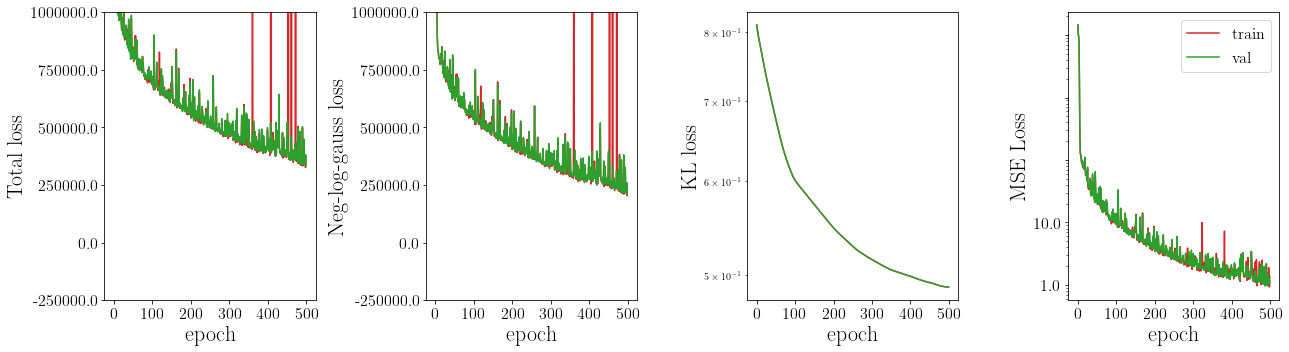

In [57]:
fig, axs = plt.subplots( 1, 4, figsize=(18,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs[0].plot( trn_losses, label="train", color=c1 )
axs[0].plot( val_losses, label="val", color=c2 )
#axs[0].set_yscale('log')
axs[0].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[0].set_ylabel( "Total loss", fontproperties=axislabelfont )
xticks0 = [ int(x) for x in axs[0].get_xticks() ]
axs[0].set_xticklabels( xticks0, fontproperties=tickfont )
yticks0 = axs[0].get_yticks()
axs[0].set_yticklabels( yticks0, fontproperties=tickfont )
axs[0].set_ylim( (-4,1) )

axs[1].plot( trn_nl_losses, label="train", color=c1 )
axs[1].plot( val_nl_losses, label="val", color=c2 )
#axs[1].set_yscale('log')
axs[1].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[1].set_ylabel( "Neg-log-gauss loss", fontproperties=axislabelfont )
xticks1 = [ int(x) for x in axs[1].get_xticks() ]
axs[1].set_xticklabels( xticks1, fontproperties=tickfont )
yticks1 = axs[1].get_yticks()
axs[1].set_yticklabels( yticks1, fontproperties=tickfont )
axs[1].set_ylim( (-4,1) )

axs[2].plot( trn_kl_losses, label="train", color=c1 )
axs[2].plot( val_kl_losses, label="val", color=c2 )
axs[2].set_yscale('log')
axs[2].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[2].set_ylabel( "KL loss", fontproperties=axislabelfont )
xticks2 = [ int(x) for x in axs[2].get_xticks() ]
axs[2].set_xticklabels( xticks2, fontproperties=tickfont )
yticks2 = axs[2].get_yticks()
axs[2].set_yticklabels( yticks2, fontproperties=tickfont )

axs[3].plot( trn_mse_losses, label="train", color=c1 )
axs[3].plot( val_mse_losses, label="val", color=c2 )
axs[3].set_yscale('log')
axs[3].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[3].set_ylabel( "MSE Loss", fontproperties=axislabelfont )
xticks2 = [ int(x) for x in axs[2].get_xticks() ]
axs[3].set_xticklabels( xticks2, fontproperties=tickfont )
yticks2 = axs[2].get_yticks()
axs[3].set_yticklabels( yticks2, fontproperties=tickfont )
axs[3].legend( loc='best', prop=tickfont )


fig.tight_layout()

We can see that both the train and validation losses are being reduced during training, the model is fitting well!

## Study the results

Now we want to get some visualisation of how well our amplitude regression has worked.

The simplest thing we can do is to pass our data through the neural network to get a predicted amplitude for each event, then histogram this and compare it to the histogram of the true amplitudes.

In [58]:
def get_prediction( model, dataloader, n_monte=30):
    

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        
        # sample from weight distributions
        amps_samples = []
        sigma2_samples = []
        for i in range(n_monte):
            print(f"Evaluating prediction: {i+1} / {n_monte}")
            
            # go through dataset
            amps = []
            sigma2 = []
            for X, y in dataloader:
                pred = model( X ).detach().numpy()
                amps.extend(pred[:, 0]) # dimensions: [batch_size, 2]
                sigma2.extend(np.exp(pred[:, 1]))

            amps_samples.append(amps)
            sigma2_samples.append(sigma2)
           
    # dimensionaility (n_monte, batch_size)
    amps_samples = np.stack(amps_samples, axis=0)
    sigma2_samples = np.stack(sigma2_samples, axis=0)
                
    return amps_samples, sigma2_samples


In [59]:
# TURN OFF shuffeling to not mess up the weight sampling!
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=False )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=False )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=False )

# dimensionality is (n_monte, batch_size)
pred_trn_ampls_samples, sigma2_trn_samples = get_prediction( model, trn_dataloader )
pred_val_ampls_samples, sigma2_val_samples = get_prediction( model, val_dataloader )

# compute mean prediction, standard deviation of predictions and mean sigma-output
pred_trn_ampls = np.mean(pred_trn_ampls_samples, axis=0) # mean prediction
pred_trn_ampls_std = np.std(pred_trn_ampls_samples, axis=0)
pred_trn_ampls_std_stoch = np.sqrt(np.mean(sigma2_trn_samples, axis=0))
pred_trn_ampls_std_tot = np.sqrt(pred_trn_ampls_std**2 + pred_trn_ampls_std_stoch**2)

# same for validation data
pred_val_ampls = np.mean(pred_val_ampls_samples, axis=0) # mean prediction
pred_val_ampls_std = np.std(pred_val_ampls_samples, axis=0)
pred_val_ampls_std_stoch = np.sqrt(np.mean(sigma2_val_samples, axis=0))
pred_val_ampls_std_tot = np.sqrt(pred_val_ampls_std**2 + pred_val_ampls_std_stoch**2)

print("Mean std pred: ", np.mean(pred_trn_ampls_std))
print("Mean std stoch: ", np.mean(pred_trn_ampls_std_stoch))


Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating prediction: 3 / 30
Evaluating prediction: 4 / 30
Evaluating prediction: 5 / 30
Evaluating prediction: 6 / 30
Evaluating prediction: 7 / 30
Evaluating prediction: 8 / 30
Evaluating prediction: 9 / 30
Evaluating prediction: 10 / 30
Evaluating prediction: 11 / 30
Evaluating prediction: 12 / 30
Evaluating prediction: 13 / 30
Evaluating prediction: 14 / 30
Evaluating prediction: 15 / 30
Evaluating prediction: 16 / 30
Evaluating prediction: 17 / 30
Evaluating prediction: 18 / 30
Evaluating prediction: 19 / 30
Evaluating prediction: 20 / 30
Evaluating prediction: 21 / 30
Evaluating prediction: 22 / 30
Evaluating prediction: 23 / 30
Evaluating prediction: 24 / 30
Evaluating prediction: 25 / 30
Evaluating prediction: 26 / 30
Evaluating prediction: 27 / 30
Evaluating prediction: 28 / 30
Evaluating prediction: 29 / 30
Evaluating prediction: 30 / 30
Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating predicti

First for the training data:

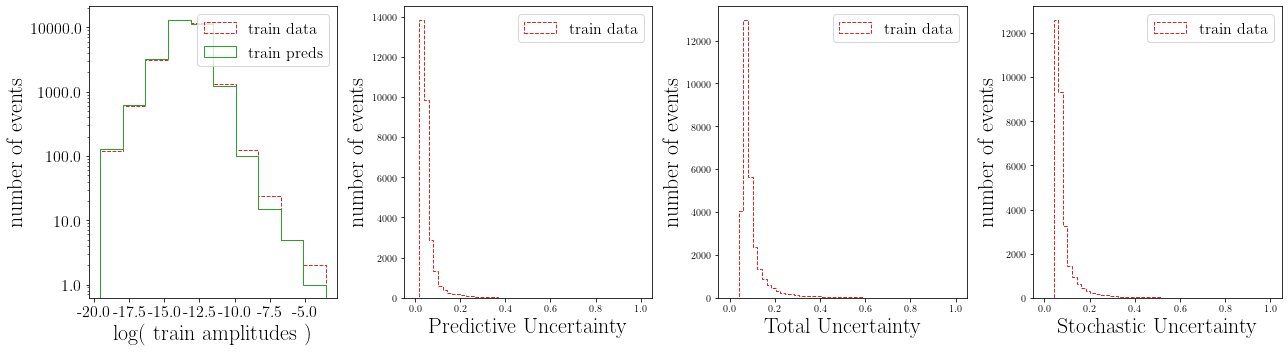

In [60]:
fig, axs = plt.subplots( 1, 4, figsize=(18,5) )

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1 ) = axs[0].hist( trn_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--" )
(n2, bins, patches2 ) = axs[0].hist( pred_trn_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="train preds", bins=bins )

bins= np.linspace(0, 1., 50)
(n3, bins, patches3 ) = axs[1].hist( pred_trn_ampls_std, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--" )
(n4, bins, patches4 ) = axs[2].hist( pred_trn_ampls_std_tot, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--" )
(n5, bins, patches5 ) = axs[3].hist( pred_trn_ampls_std_stoch, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--" )

axs[0].set_yscale( 'log' )
axs[0].set_xlabel( "log( train amplitudes )", fontproperties=axislabelfont )
axs[0].set_ylabel( "number of events", fontproperties=axislabelfont )
xticks = axs[0].get_xticks()
axs[0].set_xticklabels( xticks, fontproperties=tickfont )
yticks = axs[0].get_yticks()
axs[0].set_yticklabels( yticks, fontproperties=tickfont )
axs[0].legend( loc='best', prop=tickfont )

axs[1].set_xlabel( "Predictive Uncertainty", fontproperties=axislabelfont )
axs[1].set_ylabel( "number of events", fontproperties=axislabelfont )
axs[1].legend( loc='best', prop=tickfont )

axs[2].set_xlabel( "Total Uncertainty ", fontproperties=axislabelfont )
axs[2].set_ylabel( "number of events", fontproperties=axislabelfont )
axs[2].legend( loc='best', prop=tickfont )

axs[3].set_xlabel( "Stochastic Uncertainty", fontproperties=axislabelfont )
axs[3].set_ylabel( "number of events", fontproperties=axislabelfont )
axs[3].legend( loc='best', prop=tickfont )


fig.tight_layout()

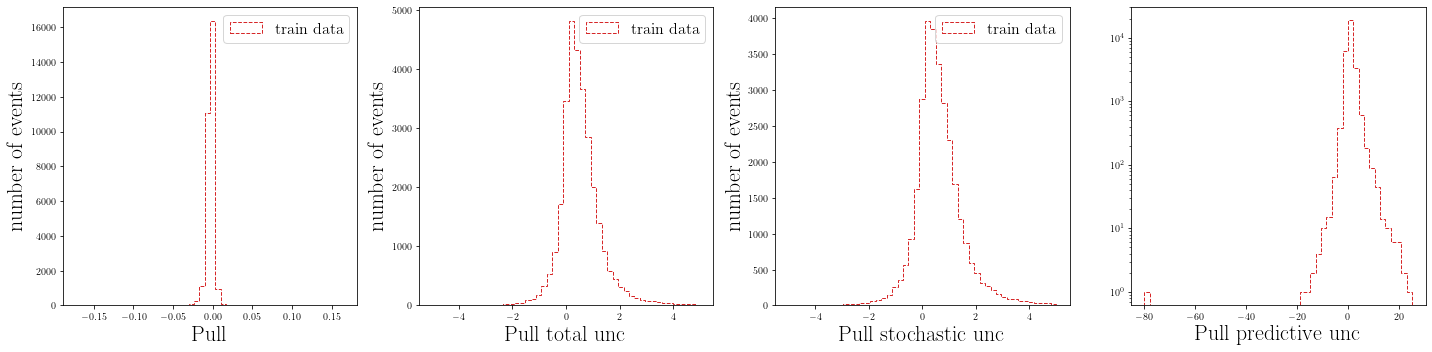

In [61]:
fig, axs = plt.subplots( 1, 4, figsize=(20,5) )

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins = np.linspace(-5, 5, n_bins)

pull = (trn_ampl - pred_trn_ampls) / trn_ampl
pull_normalized_tot = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std_tot
pull_normalized_stoch = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std_stoch
pull_normalized = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std


(n1, bins1, patches1 ) = axs[0].hist( pull, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )
(n2, bins2, patches2 ) = axs[1].hist( pull_normalized_tot, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n3, bins3, patches3 ) = axs[2].hist( pull_normalized_stoch, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n4, bins4, patches4 ) = axs[3].hist( pull_normalized, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )

#axs[0].set_yscale( 'log' )
axs[0].set_xlabel( "Pull", fontproperties=axislabelfont )
axs[0].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[0].get_xticks()
#axs[0].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[0].get_yticks()
#axs[0].set_yticklabels( yticks, fontproperties=tickfont )
axs[0].legend( loc='best', prop=tickfont )

#axs[1].set_yscale( 'log' )
axs[1].set_xlabel( "Pull total unc", fontproperties=axislabelfont )
axs[1].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[1].get_xticks()
#axs[1].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[1].get_yticks()
#axs[1].set_yticklabels( yticks, fontproperties=tickfont )
axs[1].legend( loc='best', prop=tickfont )

#axs[2].set_yscale( 'log' )
axs[2].set_xlabel( "Pull stochastic unc", fontproperties=axislabelfont )
axs[2].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[2].get_xticks()
#axs[2].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[2].get_yticks()
#axs[2].set_yticklabels( yticks, fontproperties=tickfont )
axs[2].legend( loc='best', prop=tickfont )

axs[3].set_yscale( 'log' )
axs[3].set_xlabel( "Pull predictive unc", fontproperties=axislabelfont )
#axs[3].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[3].get_xticks()
#axs[3].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[3].get_yticks()
#axs[3].set_yticklabels( yticks, fontproperties=tickfont )
#axs[3].legend( loc='best', prop=tickfont )

fig.tight_layout()

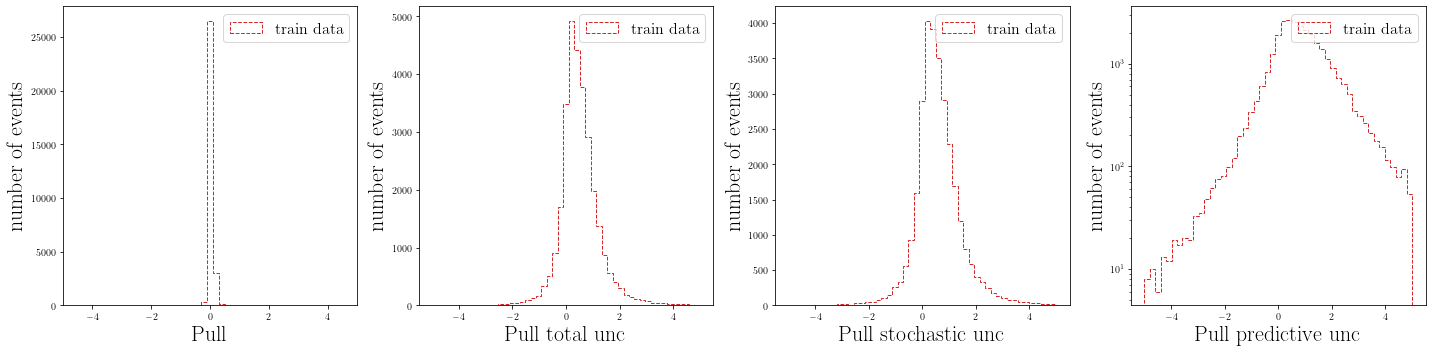

In [62]:
# same plots for exp(log (train amplitudes) ) = train amplitudes

fig, axs = plt.subplots( 1, 4, figsize=(20,5) )

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins =np.linspace(-5, 5, n_bins)

# revert preprocessing
trn_ampl_exp = np.exp(trn_ampl)
pred_trn_ampls_exp = np.exp(pred_trn_ampls)
pred_val_ampls_std_tot_exp = np.exp(trn_ampl) * pred_val_ampls_std_tot # error propagation
pred_val_ampls_std_stoch_exp = np.exp(trn_ampl) * pred_val_ampls_std_stoch # error propagation
pred_val_ampls_std_exp = np.exp(trn_ampl) * pred_val_ampls_std # error propagation

pull = (trn_ampl_exp - pred_trn_ampls_exp) / trn_ampl_exp
pull_normalized_tot = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_tot_exp
pull_normalized_stoch = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_stoch_exp
pull_normalized = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_exp
(n1, bins1, patches1 ) = axs[0].hist( pull, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--" )
(n2, bins2, patches2 ) = axs[1].hist( pull_normalized_tot, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--" )
(n3, bins3, patches3 ) = axs[2].hist( pull_normalized_stoch, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--" )
(n4, bins4, patches4 ) = axs[3].hist( pull_normalized, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--" )


#axs[0].set_yscale( 'log' )
axs[0].set_xlabel( "Pull", fontproperties=axislabelfont )
axs[0].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[0].get_xticks()
#axs[0].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[0].get_yticks()
#axs[0].set_yticklabels( yticks, fontproperties=tickfont )
axs[0].set_xlim([-5, 5])
axs[0].legend( loc='best', prop=tickfont )

#axs[1].set_yscale( 'log' )
axs[1].set_xlabel( "Pull total unc", fontproperties=axislabelfont )
axs[1].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[1].get_xticks()
#axs[1].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[1].get_yticks()
#axs[1].set_yticklabels( yticks, fontproperties=tickfont )
axs[1].legend( loc='best', prop=tickfont )

#axs[2].set_yscale( 'log' )
axs[2].set_xlabel( "Pull stochastic unc", fontproperties=axislabelfont )
axs[2].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[2].get_xticks()
#axs[2].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[2].get_yticks()
#axs[2].set_yticklabels( yticks, fontproperties=tickfont )
axs[2].legend( loc='best', prop=tickfont )

axs[3].set_yscale( 'log' )
axs[3].set_xlabel( "Pull predictive unc", fontproperties=axislabelfont )
axs[3].set_ylabel( "number of events", fontproperties=axislabelfont )
#xticks = axs[3].get_xticks()
#axs[3].set_xticklabels( xticks, fontproperties=tickfont )
#yticks = axs[3].get_yticks()
#axs[3].set_yticklabels( yticks, fontproperties=tickfont )
axs[3].legend( loc='best', prop=tickfont )

fig.tight_layout()

The error is lowest in the regions where there is more training data, this is expected.  The more data the network has to learn from, the better it can learn to predict the correct amplitude.

And then for the validation data:

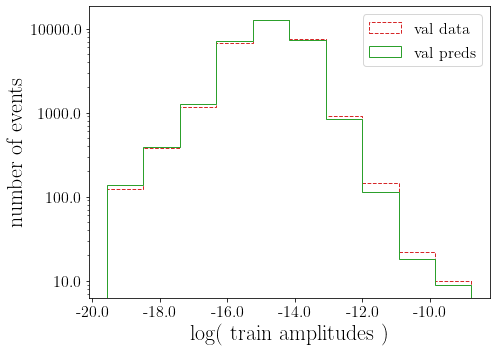

In [63]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1) = axs.hist( val_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="val data", ls="--" )
(n2, bins, patches2) = axs.hist( pred_val_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="val preds", bins=bins )

axs.set_yscale( 'log' )

axs.set_xlabel( "log( train amplitudes )", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

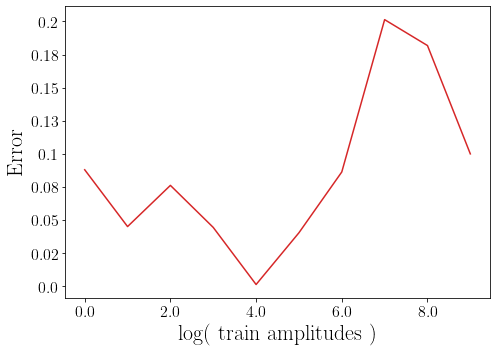

In [64]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( np.abs((n1-n2)/n1), color=c1 )

axs.set_xlabel( "log( train amplitudes )", fontproperties=axislabelfont )
axs.set_ylabel( "Error", fontproperties=axislabelfont )

xticks = np.round( axs.get_xticks(), 2 )
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = np.round( axs.get_yticks(), 2 )
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()